# Classification de documents

## Imports

In [15]:
# -------------------------------
# 1️IMPORTS
# -------------------------------
import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -------------------------------
# 2️ CHARGEMENT DES TEXTES
# -------------------------------
data_path = "../../data/txt_tp4/"  # dossier contenant les .txt
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]
print("Nombre de documents chargés :", len(texts))




Nombre de documents chargés : 999


[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Exemple : filtrer articles contenant "sorcière" et "féminité"
def matches_query(text):
    text_lower = text.lower()
    cond1 = "sorcière" in text_lower or "sorciere" in text_lower
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", text_lower))
    return cond1 and cond2

filtered_texts = [t for t in texts if matches_query(t)]
print("Documents après filtrage :", len(filtered_texts))

# Nettoyage simple : supprimer bruit (ex : petites annonces)
def is_noise(text):
    if len(re.findall(r"\d{3,}", text)) > 30: return True
    if len(re.findall(r"\b\d{2}h\d{2}\b|\b\d{4}\b", text)) > 20: return True
    return False

clean_texts = [t for t in filtered_texts if not is_noise(t)]
print("Documents après nettoyage :", len(clean_texts))


Documents après filtrage : 993
Documents après nettoyage : 320


In [17]:
#PRETRAITEMENT (tokenization, stemming)
# -------------------------------
stemmer = FrenchStemmer()
def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(t) for t in tokens if len(t) > 2]
    return tokens


In [18]:
# 5️⃣ TF-IDF
# -------------------------------
vectorizer = TfidfVectorizer(
    tokenizer=preprocess,
    stop_words=stopwords.words("french") + ["comme","ainsi","cela","cette","etc"],
    min_df=3,
    max_df=0.4
)
X_tfidf = vectorizer.fit_transform(clean_texts)
print("Shape TF-IDF :", X_tfidf.shape)

/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/ilaria/Desktop/STIC/traitement_auto_corpus/tac/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ains', 'aur', 'aurion', 'auron', 'avi', 'avion', 'avon', 'ayon', 'cel', 'cet', 'comm', 'dan', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'mêm', 'notr', 'ser', 'serion', 'seron', 'soi', 'somm', 'soyon', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Shape TF-IDF : (320, 16384)


Exemple de clusters : [0 5 0 0 2 5 3 0 0 3]


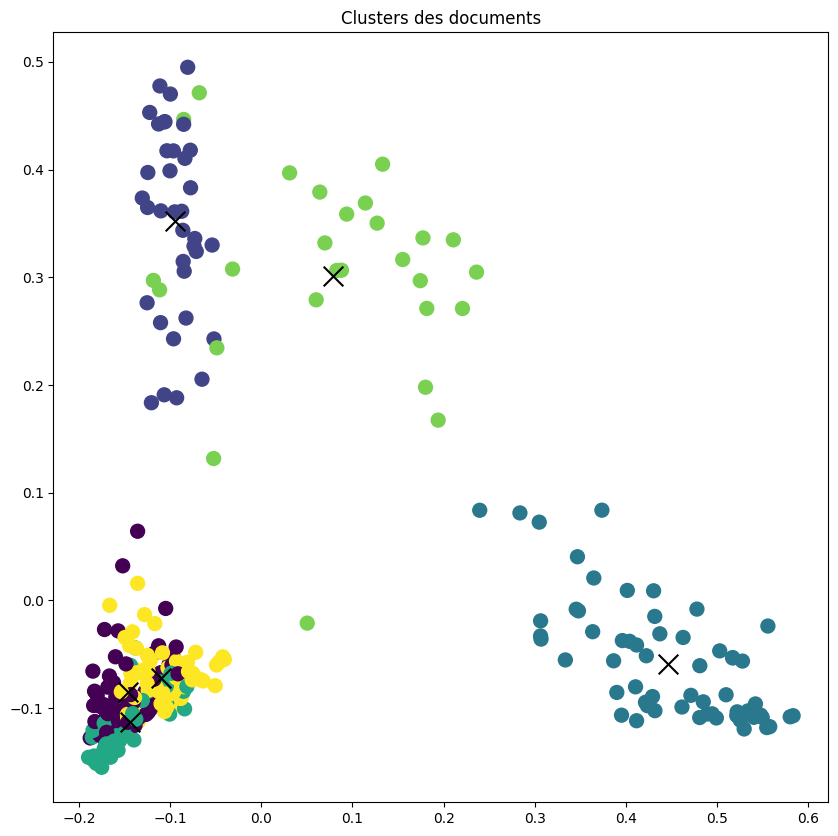

In [ ]:
# Clustering Kmeans
N_CLUSTERS = 6
km_model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = km_model.fit_predict(X_tfidf)
print("Exemple de clusters :", clusters[:10])

# Visualisation PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_tfidf.toarray())
plt.figure(figsize=(10,10))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clusters, s=100)
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=200, color="black")
plt.title("Clusters des documents")
plt.show()


In [23]:
# Utilisation des clusters comme features additionnelles
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# One-hot encoder pour les clusters
encoder = OneHotEncoder(sparse_output=False)  # ancien 'sparse=False' → maintenant 'sparse_output=False'
clusters_onehot = encoder.fit_transform(clusters.reshape(-1, 1))

# Combiner TF-IDF + clusters
# X_tfidf est un sparse matrix, clusters_onehot est dense, on convertit dense en sparse pour hstack
from scipy.sparse import csr_matrix
X_features = hstack([X_tfidf, csr_matrix(clusters_onehot)])
print("Shape features combinées :", X_features.shape)

Shape features combinées : (320, 16390)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00        15

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



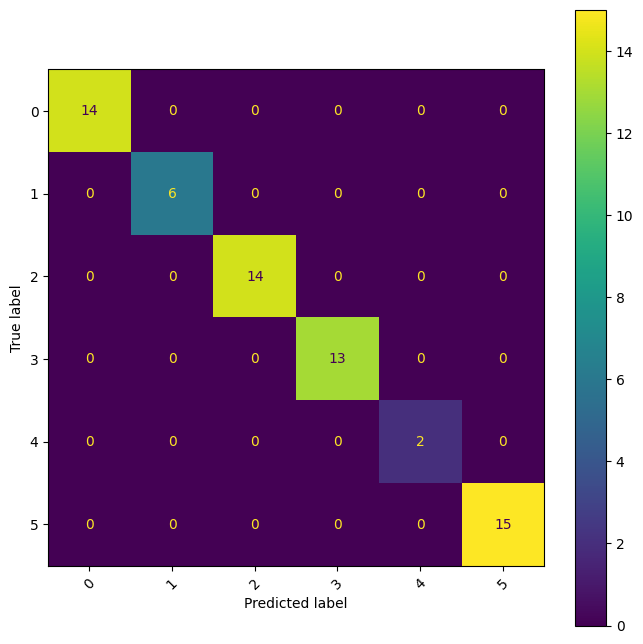

In [24]:
# classification supervisée
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_label = clusters  # ou tes vrais labels si disponibles

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=42)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Rapport
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_label))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45)
plt.show()



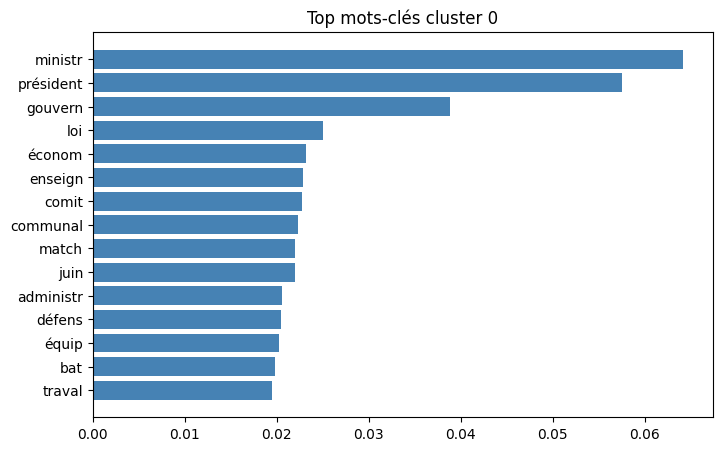

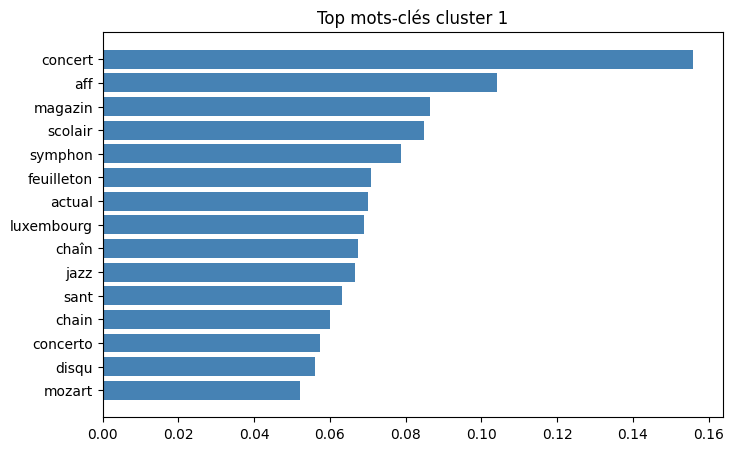

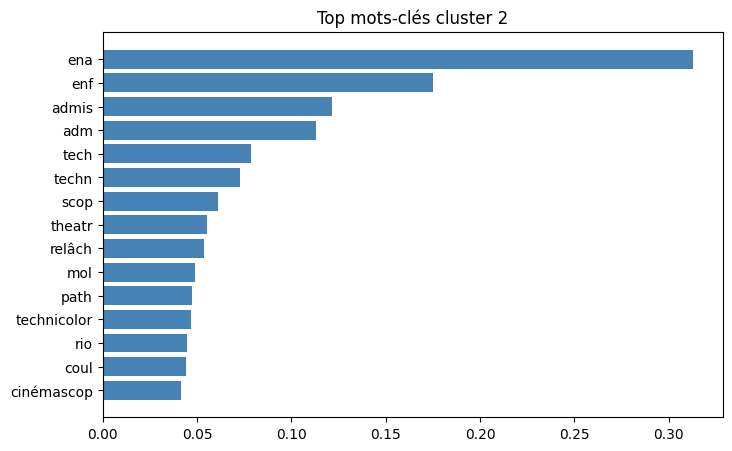

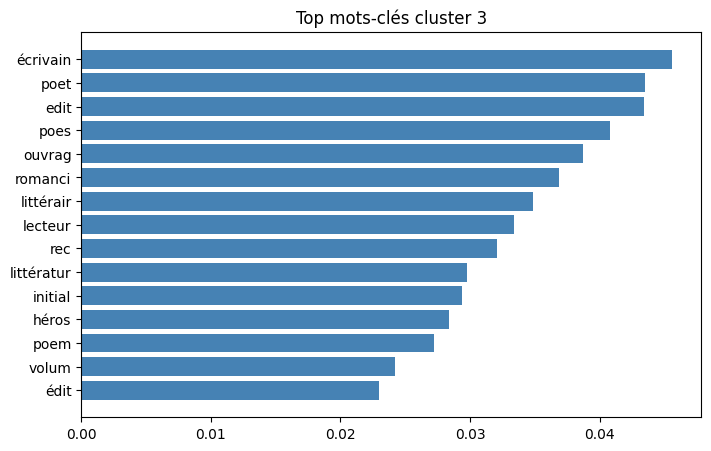

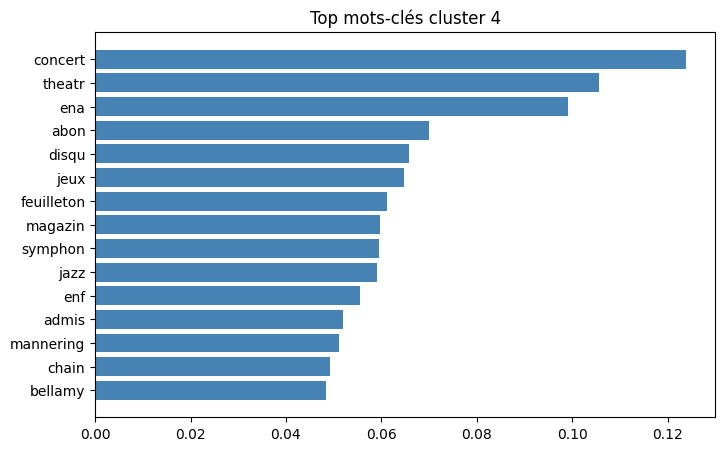

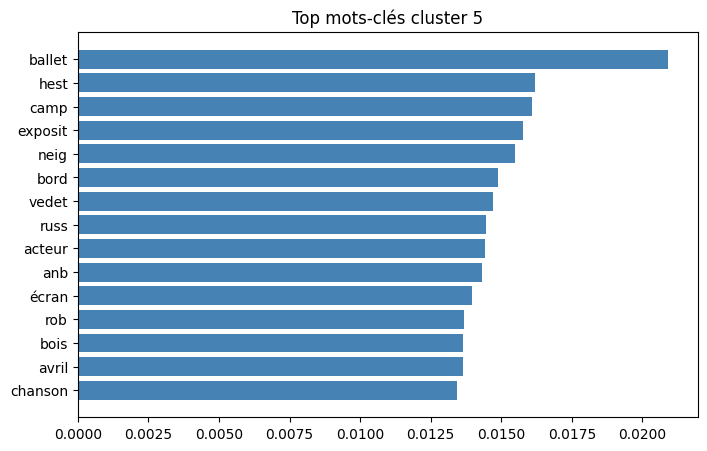

In [25]:
# Top mots-clés par cluster
terms = vectorizer.get_feature_names_out()
centers = km_model.cluster_centers_

for i in range(N_CLUSTERS):
    top_idx = centers[i].argsort()[-15:][::-1]
    top_words = [terms[j] for j in top_idx]
    top_scores = [centers[i][j] for j in top_idx]
    plt.figure(figsize=(8,5))
    plt.barh(top_words[::-1], top_scores[::-1], color="steelblue")
    plt.title(f"Top mots-clés cluster {i}")
    plt.show()